In [1]:
"""
Train an SVR model for SBI using:
- 1H main timeframe
- 4H higher timeframe
- 15m microstructure (aggregated to 1H)

Files used (must be in the same folder):
- SBI_Bank_1H_IST_market_hours.csv
- SBI_Bank_4H_IST_market_hours.csv
- SBI_Bank_15min_IST_market_hours.csv
"""

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import pickle

# ===================== FILE PATHS =====================
PATH_1H = "SBI_Bank_1H_IST_market_hours.csv"
PATH_4H = "SBI_Bank_4H_IST_market_hours.csv"
PATH_15M = "SBI_Bank_15min_IST_market_hours.csv"

OUTPUT_MODEL = "svr_SBI_multi_tf_1h.pkl"
# ======================================================


# ---------- Helper functions for indicators ----------
def compute_ema(series: pd.Series, span: int) -> pd.Series:
    """Exponential moving average"""
    return series.ewm(span=span, adjust=False).mean()


def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """Simple RSI implementation"""
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)

    gain_ema = pd.Series(gain, index=series.index).ewm(alpha=1/period, adjust=False).mean()
    loss_ema = pd.Series(loss, index=series.index).ewm(alpha=1/period, adjust=False).mean()

    rs = gain_ema / (loss_ema + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_macd(series: pd.Series,
                 fast: int = 12,
                 slow: int = 26,
                 signal: int = 9) -> pd.DataFrame:
    ema_fast = compute_ema(series, fast)
    ema_slow = compute_ema(series, slow)
    macd = ema_fast - ema_slow
    signal_line = compute_ema(macd, signal)
    hist = macd - signal_line
    return pd.DataFrame({"macd": macd, "signal": signal_line, "macd_hist": hist})


def compute_atr(high: pd.Series,
                low: pd.Series,
                close: pd.Series,
                period: int = 14) -> pd.Series:
    """Average True Range"""
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr


# ------------- Prepare 1H dataframe ----------------
def prepare_1h(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # convert IST string to datetime index
    df["datetime_ist"] = pd.to_datetime(df["datetime_ist"])
    df = df.set_index("datetime_ist").sort_index()

    # rename columns so we know they are 1H
    df = df.rename(columns={
        "open": "open_1h",
        "high": "high_1h",
        "low": "low_1h",
        "close": "close_1h",
        "volume": "volume_1h",
        "timestamp": "timestamp_1h",
    })

    # price action
    df["body_1h"] = df["close_1h"] - df["open_1h"]
    df["range_1h"] = df["high_1h"] - df["low_1h"]
    df["upper_wick_1h"] = df["high_1h"] - df[["open_1h", "close_1h"]].max(axis=1)
    df["lower_wick_1h"] = df[["open_1h", "close_1h"]].min(axis=1) - df["low_1h"]
    df["body_ratio_1h"] = df["body_1h"] / (df["range_1h"] + 1e-10)
    df["direction_1h"] = np.sign(df["body_1h"])

    # returns & volatility
    df["ret_1h"] = df["close_1h"].pct_change()
    df["ret_1h_3"] = df["close_1h"].pct_change(3)
    df["volatility_1h_10"] = df["ret_1h"].rolling(10).std()

    # volume ma
    df["vol_ma_1h_20"] = df["volume_1h"].rolling(20).mean()

    # indicators
    df["ema_1h_20"] = compute_ema(df["close_1h"], 20)
    df["ema_1h_50"] = compute_ema(df["close_1h"], 50)
    df["rsi_1h_14"] = compute_rsi(df["close_1h"], 14)
    df["atr_1h_14"] = compute_atr(df["high_1h"], df["low_1h"], df["close_1h"], 14)

    macd_df = compute_macd(df["close_1h"])
    df["macd_1h"] = macd_df["macd"]
    df["macd_signal_1h"] = macd_df["signal"]
    df["macd_hist_1h"] = macd_df["macd_hist"]

    return df


# ------------- Prepare 4H dataframe ----------------
def prepare_4h(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df["datetime_ist"] = pd.to_datetime(df["datetime_ist"])
    df = df.set_index("datetime_ist").sort_index()

    df = df.rename(columns={
        "open": "open_4h",
        "high": "high_4h",
        "low": "low_4h",
        "close": "close_4h",
        "volume": "volume_4h",
        "timestamp": "timestamp_4h",
    })

    # price action
    df["body_4h"] = df["close_4h"] - df["open_4h"]
    df["range_4h"] = df["high_4h"] - df["low_4h"]
    df["upper_wick_4h"] = df["high_4h"] - df[["open_4h", "close_4h"]].max(axis=1)
    df["lower_wick_4h"] = df[["open_4h", "close_4h"]].min(axis=1) - df["low_4h"]
    df["body_ratio_4h"] = df["body_4h"] / (df["range_4h"] + 1e-10)
    df["direction_4h"] = np.sign(df["body_4h"])

    # returns & volatility
    df["ret_4h"] = df["close_4h"].pct_change()
    df["volatility_4h_10"] = df["ret_4h"].rolling(10).std()
    df["vol_ma_4h_20"] = df["volume_4h"].rolling(20).mean()

    # indicators
    df["ema_4h_50"] = compute_ema(df["close_4h"], 50)
    df["rsi_4h_14"] = compute_rsi(df["close_4h"], 14)
    df["atr_4h_14"] = compute_atr(df["high_4h"], df["low_4h"], df["close_4h"], 14)

    macd_df = compute_macd(df["close_4h"])
    df["macd_4h"] = macd_df["macd"]
    df["macd_signal_4h"] = macd_df["signal"]
    df["macd_hist_4h"] = macd_df["macd_hist"]

    return df


# ---- Prepare 15M microstructure aggregated to 1H ----
def prepare_15m_microstructure(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df["datetime_ist"] = pd.to_datetime(df["datetime_ist"])
    df = df.set_index("datetime_ist").sort_index()

    # basic 15m price action
    df["body_15m"] = df["close"] - df["open"]
    df["range_15m"] = df["high"] - df["low"]
    df["is_green_15m"] = (df["close"] > df["open"]).astype(int)

    # aggregate 15m → 1H
    agg = {
        "volume": "sum",
        "range_15m": "mean",
        "body_15m": "mean",
        "is_green_15m": "mean",
    }

    df_agg = df.resample("1H").agg(agg)

    # rename columns so meaning is clear
    df_agg = df_agg.rename(columns={
        "volume": "vol_sum_15m_in_1h",
        "range_15m": "range_mean_15m_in_1h",
        "body_15m": "body_mean_15m_in_1h",
        "is_green_15m": "green_ratio_15m_in_1h",
    })

    return df_agg


# --------- Build final merged dataset ---------
def build_dataset() -> pd.DataFrame:
    df_1h = prepare_1h(PATH_1H)
    df_4h = prepare_4h(PATH_4H)
    df_15m_micro = prepare_15m_microstructure(PATH_15M)

    # merge 4H into 1H (each 1H gets latest completed 4H candle)
    df_merged = pd.merge_asof(
        df_1h.sort_index(),
        df_4h.sort_index(),
        left_index=True,
        right_index=True,
        direction="backward"
    )

    # merge 15m microstructure into 1H
    df_merged = pd.merge_asof(
        df_merged.sort_index(),
        df_15m_micro.sort_index(),
        left_index=True,
        right_index=True,
        direction="backward"
    )

    # target: next 1H return
    df_merged["future_return_1h"] = (
        df_merged["close_1h"].shift(-1) / df_merged["close_1h"] - 1
    )

    # drop rows with any NaNs (indicators, merges, target)
    df_merged = df_merged.dropna()

    return df_merged


# -------------- Train SVR model --------------
def train_and_save_model():
    df = build_dataset()

    # columns that should NOT go into model
    exclude_cols = [
        "future_return_1h",
        "timestamp_1h",
        "timestamp_4h",
    ]

    feature_cols = [c for c in df.columns if c not in exclude_cols]

    X = df[feature_cols]
    y = df["future_return_1h"]

    # time-based split: 80% train, 20% test
    n = len(df)
    split_idx = int(n * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # pipeline: scale features → SVR
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf", C=1.0, epsilon=0.0005))
    ])

    pipeline.fit(X_train, y_train)

    # quick evaluation
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE (future_return_1h): {rmse:.8f}")
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # save model + feature names
    artifact = {
        "model": pipeline,
        "feature_cols": feature_cols,
        "target": "future_return_1h",
        "description": "SVR model for next 1H return using 1H + 4H + 15m microstructure",
    }

    with open(OUTPUT_MODEL, "wb") as f:
        pickle.dump(artifact, f)

    print(f"Model saved to: {OUTPUT_MODEL}")


if __name__ == "__main__":
    train_and_save_model()


Test RMSE (future_return_1h): 0.00540307
Train samples: 392, Test samples: 98
Model saved to: svr_SBI_multi_tf_1h.pkl


C:\Users\jainu\AppData\Local\Temp\ipykernel_16332\1973550977.py:186: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_agg = df.resample("1H").agg(agg)


In [3]:
# Load model
with open("svr_SBI_multi_tf_1h.pkl", "rb") as f:
    artifact = pickle.load(f)

model = artifact["model"]
feature_cols = artifact["feature_cols"]

# Rebuild dataset
df = build_dataset()

# Last row for testing
X_last = df[feature_cols].iloc[-1:].copy()
y_pred = model.predict(X_last)[0]

print("Predicted next 1H return:", y_pred)

# Trading bias
if y_pred > 0.0003:
    print(" → Model says: BUY")
elif y_pred < -0.0003:
    print(" → Model says: SELL")
else:
    print(" → Model says: NO TRADE")


Predicted next 1H return: 0.002178364652224178
 → Model says: BUY


C:\Users\jainu\AppData\Local\Temp\ipykernel_16332\1973550977.py:186: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_agg = df.resample("1H").agg(agg)


C:\Users\jainu\AppData\Local\Temp\ipykernel_16332\1973550977.py:186: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_agg = df.resample("1H").agg(agg)



==== SIGNAL MODE: QUANTILE ====
Thresholds: {'long': np.float64(0.0013349908421458898), 'short': np.float64(-0.0023465381475761965)}

=== STATS ===
{'num_trades': 61, 'win_rate': np.float64(0.6557377049180327), 'total_return': np.float64(0.03836176091153343), 'avg_trade_return': np.float64(0.0006212463338865501), 'max_drawdown': np.float64(0.008799264314316435)}

=== SAMPLE TRADES ===
                 entry_time direction  entry_price                 exit_time  \
0 2025-03-05 15:30:00+05:30       BUY       730.35 2025-03-06 09:30:00+05:30   
1 2025-03-06 09:30:00+05:30      SELL       730.50 2025-03-06 10:30:00+05:30   
2 2025-03-06 11:30:00+05:30       BUY       731.85 2025-03-06 12:30:00+05:30   
3 2025-03-06 12:30:00+05:30      SELL       732.00 2025-03-06 13:30:00+05:30   
4 2025-03-06 15:30:00+05:30      SELL       732.05 2025-03-07 09:30:00+05:30   

   exit_price  return_pct  
0      730.50    0.000205  
1      730.25    0.000342  
2      732.00    0.000205  
3      732.70   -0

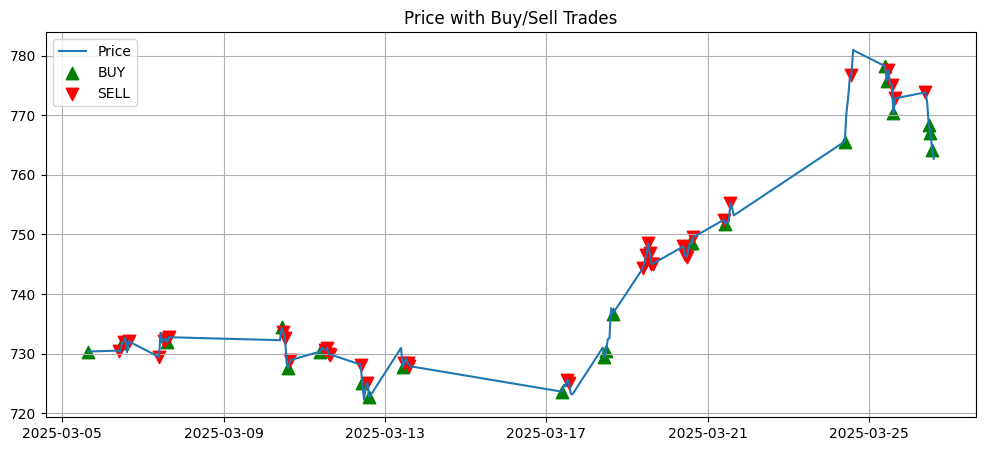

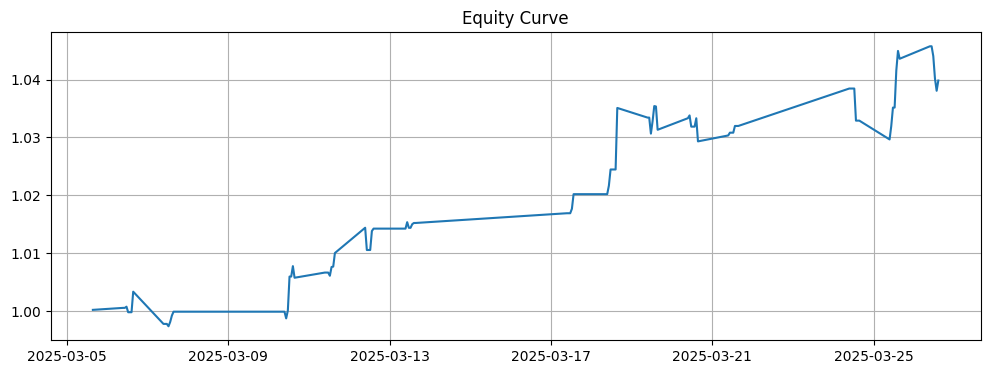

In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

MODEL_PATH = "svr_SBI_multi_tf_1h.pkl"

# ----------------- Load model + data -----------------

def load_model_and_data():
    with open(MODEL_PATH, "rb") as f:
        artifact = pickle.load(f)

    model = artifact["model"]
    feature_cols = artifact["feature_cols"]

    df = build_dataset()

    n = len(df)
    split_idx = int(n * 0.8)

    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()

    df_train["pred_return"] = model.predict(df_train[feature_cols])
    df_test["pred_return"] = model.predict(df_test[feature_cols])

    return model, df_train, df_test, feature_cols


# ----------------- Generate signals -----------------

def generate_signals(df_train, df_test, mode="quantile"):

    train_preds = df_train["pred_return"].values
    test_preds = df_test["pred_return"].values

    thresholds = {}

    if mode == "threshold":
        long_thr = 0.0003
        short_thr = -0.0003

    elif mode == "quantile":
        long_thr = np.quantile(train_preds, 0.70)
        short_thr = np.quantile(train_preds, 0.30)

    elif mode == "tercile":
        long_thr = np.quantile(train_preds, 2/3)
        short_thr = np.quantile(train_preds, 1/3)

    thresholds["long"] = long_thr
    thresholds["short"] = short_thr

    sig = np.where(test_preds >= long_thr, 1,
          np.where(test_preds <= short_thr, -1, 0))

    df = df_test.copy()
    df["signal"] = sig

    return df, thresholds


# ----------------- Backtesting -----------------

def run_backtest(df):
    df = df.copy()

    trades = []
    closes = df["close_1h"].values
    signals = df["signal"].values
    idx = df.index.to_list()

    for i in range(len(df)-1):

        if signals[i] == 0:
            continue

        entry_price = closes[i]
        exit_price = closes[i+1]

        direction = "BUY" if signals[i] == 1 else "SELL"

        if signals[i] == 1:
            ret = (exit_price / entry_price) - 1
        else:
            ret = (entry_price / exit_price) - 1

        trades.append({
            "entry_time": idx[i],
            "direction": direction,
            "entry_price": entry_price,
            "exit_time": idx[i+1],
            "exit_price": exit_price,
            "return_pct": ret
        })

    trades_df = pd.DataFrame(trades)

    df["pnl_pct"] = df["signal"] * df["future_return_1h"]
    df["equity_curve"] = (1 + df["pnl_pct"]).cumprod()

    stats = {
        "num_trades": len(trades_df),
        "win_rate": (trades_df["return_pct"] > 0).mean() if len(trades_df)>0 else 0,
        "total_return": trades_df["return_pct"].add(1).prod() - 1 if len(trades_df)>0 else 0,
        "avg_trade_return": trades_df["return_pct"].mean() if len(trades_df)>0 else 0,
        "max_drawdown": (df["equity_curve"].cummax() - df["equity_curve"]).max()
    }

    return trades_df, df, stats


# ----------------- Plotting -----------------

def plot_trades(df, trades_df):
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df["close_1h"], label="Price")

    buys = trades_df[trades_df["direction"]=="BUY"]
    sells = trades_df[trades_df["direction"]=="SELL"]

    plt.scatter(buys["entry_time"], buys["entry_price"], marker="^", s=80, color="green", label="BUY")
    plt.scatter(sells["entry_time"], sells["entry_price"], marker="v", s=80, color="red", label="SELL")

    plt.title("Price with Buy/Sell Trades")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_equity(df):
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["equity_curve"], label="Equity Curve")
    plt.title("Equity Curve")
    plt.grid(True)
    plt.show()


# ----------------- Main Test Function -----------------

def test_model(mode="quantile"):
    model, df_train, df_test, feature_cols = load_model_and_data()

    df_sig, thr = generate_signals(df_train, df_test, mode=mode)

    trades_df, df_bt, stats = run_backtest(df_sig)

    print("\n==== SIGNAL MODE:", mode.upper(), "====")
    print("Thresholds:", thr)
    print("\n=== STATS ===")
    print(stats)
    print("\n=== SAMPLE TRADES ===")
    print(trades_df.head())

    plot_trades(df_bt, trades_df)
    plot_equity(df_bt)

    return trades_df, df_bt, stats


# ---- DEFAULT RUN ----
trades, df_bt, stats = test_model(mode="quantile")   # or "threshold" or "tercile"
